# Import

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from CMEP import CMEP_Atom
from qsps import QSP_HNC
from constants import *
# from hnc_Ng import  HNC_solver
# from qsps import *

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
        
        
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Ha_to_J = 4.359744e-18
k_B = 1.380649e-23 
m_p = 1.672621898e-27 # kg
eV_to_K = 11604.5250061598
J_to_erg = 1e7
Ha_to_erg = Ha_to_J*J_to_erg

# Function that sets up HNC QSP 

## Load TCCW Cases

CLAMS: 
if element=='Xe':
    ni_cc = 1.25e20
    Te_eV = 16.64e3/eV_to_K
    Ti_eV = 10.47e3/eV_to_K
    Z, A = 54, 131

elif element=='He':
    ni_cc = 1.83e21 # 1/m^3
    Te_eV = 14.48e3/eV_to_K
    Ti_eV = 11.66e3/eV_to_K
    Z, A = 2,4


In [307]:
ni_cc = 1e23 # 1/m^3
Te_eV = 0.2
Ti_eV = Te_eV
# Z, A = 4, 4 

ni_AU = ni_cc*1e6*aB**3

r_s_AU = QSP_HNC.rs_from_n(ni_AU)
r_c = 0
if r_c>1:
    r_c=1e-5
print("Te = {0:.3e} eV, n_i = {1:.3e} 1/cc".format(Te_eV, ni_cc))
print("Te = {0:.3e} K, ρ = {1:.3e} [g/cc] ".format(Te_eV*eV_to_K, 1e3*ni_cc*m_p*A ))
print("r_s = {0:.3f}, r_c/r_s = {1:.3f}".format(r_s_AU, r_c))

Te = 2.000e-01 eV, n_i = 1.000e+23 1/cc
Te = 2.321e+03 K, ρ = 1.673e-01 [g/cc] 
r_s = 2.526, r_c/r_s = 0.000


In [313]:
atom_names = ['H']#,"He","Li","Be"]
Z_list = [1]#,2,3,4]
atom_list =  []
for i, Z in enumerate(Z_list):
    A, Zbar = Z, Z
    atom = CMEP_Atom(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Z,
                     βu_options = {'add_bridge':True, 'pseudopotential':False}, 
                     qsp_options= {'r_c':0},
                     hnc_options= {'kappa_multiscale':10, 'R_max':2,'N_bins':300, 'h_max':2e2,
                                   'oz_method':'svt'},
                     hnc_solve_options={'alpha_Picard':0.5})
    atom.run_hnc()
    atom_list.append(atom)

Te_in_eV: 0.200
Ti_in_eV: 0.200
0: Initial condition Total Error: 2.127e+01
Exiting status 0, reverting to best index so far: 303
Final iter:304, Total Error: 9.809e-09


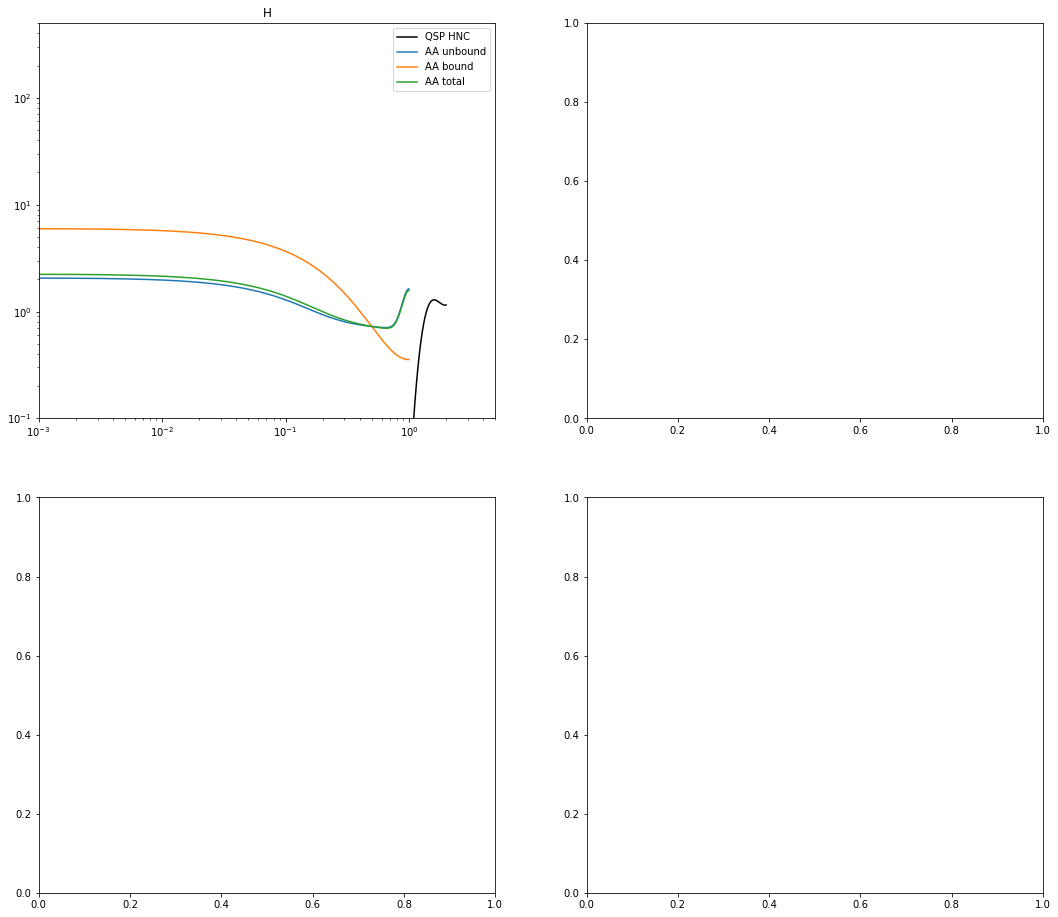

In [314]:
fig, axs = plt.subplots(2,2, figsize=(18,16))
AA_Zbar_list = [0.997, 1.968, 2.939, 3.859]
AA_Zbar_list = [0.955, 1.892, 2.772, 3.528]
folder = '/home/zach/plasma/hnc/data/'
folder = '/home/zach/plasma/atoMEC/'
AA_file_list = ['H_rs_2.526_T100eV.csv','He_rs_2.526_T100eV.csv','Li_rs_2.526_T100eV.csv','Be_rs_2.526_T100eV.csv']
for ax, Z, AA_Zbar, AA_file, atom_name, atom in zip(axs.flatten(), Z_list, AA_Zbar_list, AA_file_list, atom_names, atom_list):
    ax.set_title(atom_name)
    
    gei = (atom.hnc.h_r_matrix[0,0]+1)
    r_array   = atom.hnc.r_array

    def gei_func(r, κ=1):
        return gei[0]*(1+ 0.1*(r_array[0]/r)**-1)*np.exp(-κ*r) + 1

    ax.plot(r_array, gei,'k', label='QSP HNC')
    AA_data = read_csv(folder + AA_file, delim_whitespace=True,header=0)
    # ax.plot(r_array, gei_func(r_array,κ=15))
    ax.plot(AA_data['r[a_0]']/atom.qsp.ri,(AA_data['n[unbound]'])/AA_Zbar*4/3*π*atom.qsp.ri**3, label='AA unbound' )
    ax.plot(AA_data['r[a_0]']/atom.qsp.ri,(AA_data['n[bound]'])/(Z-AA_Zbar)*4/3*π*atom.qsp.ri**3 , label='AA bound')
    ax.plot(AA_data['r[a_0]']/atom.qsp.ri,(AA_data['n[bound]']+AA_data['n[unbound]'])/Z*4/3*π*atom.qsp.ri**3, label='AA total' )

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(1e-3,5)
    ax.set_ylim(1e-1,500)
    # ax.set_ylim(0.1*np.min(gei),10*np.max(gei))

    ax.legend()